# Hypersolvers vs purely data driven and analytical model

We want to compare the three approaches with dynamical systems whose vector field can be fully expressed by an analytical formulation here as following:

1. ODE integrators
2. Hypersolvers
3. Purely data-driven approach

Note:
These results are just to illustrate the differences and are not included in the final paper submission

In [1]:
import sys; sys.path.append(2*'../') # go n dirs back
from src import *

In [2]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.numerics import odeint, Euler, HyperEuler

## Model: damped controlled pendulum with torsional spring 

In [3]:
class ControlledPendulum(nn.Module):
    """
    Inverted pendulum with torsional spring
    """
    def __init__(self, u, m=1., k=.5, l=1., qr=0., β=1., g=9.81):
        super().__init__()
        self.u = u # controller (nn.Module)
        self.nfe = 0 # number of function evaluations
        self.cur_f = None # current function evaluation
        self.cur_u = None # current controller evaluation 
        self.m, self.k, self.l, self.qr, self.β, self.g = m, k, l, qr, β, g # physics
        
    def forward(self, t, x):
        self.nfe += 1
        q, p = x[..., :1], x[..., 1:]
        self.cur_u = self.u(t, x)
        dq = p/self.m
        dp = -self.k*(q - self.qr) - self.m*self.g*self.l*torch.sin(q) \
            -self.β*p/self.m + self.cur_u
        self.cur_f = torch.cat([dq, dp], -1)
        return self.cur_f

In [4]:
# Change device according to your configuration
# device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

In [5]:
from math import pi as π

# Time span
dt = 0.1  # this is the integration step. It is a bit large to more easily highlight the differences
t0, tf = 0, 2 # initial and final time for controlling the system
steps = int((tf - t0)/dt) + 1 # so we have a time step of 0.2s
t_span = torch.linspace(t0, tf, steps).to(device)

In [6]:
# The controller is a simple MLP with one hidden layer with bounded output
class NeuralController(nn.Module):
    def __init__(self, model, u_min=-20, u_max=20):
        super().__init__()
        self.model = model
        self.u_min, self.u_max = u_min, u_max
        
    def forward(self, t, x):
        x = self.model(x)
        return torch.clamp(x, self.u_min, self.u_max)

model = nn.Sequential(nn.Linear(2, 32), nn.Tanh(), nn.Linear(32, 1)).to(device)
u = NeuralController(model) 
for p in u.model[-1].parameters(): torch.nn.init.zeros_(p)

# Controlled system
sys = ControlledPendulum(u).to(device)

## Hypersolvers for Controlled Systems [Semi data-driven]

By training the hypersolver on residuals between the ground-truth solution and the base solver (we will use Euler in this case) we can render the training more efficient while retaining solution accuracy.

The residuals can be defined by:
\begin{equation}
\begin{aligned}
    R \left(t_k,  x(t_k), x(t_{k+1}) \right) = \Phi(x(t_k), t_k, t_{k+1}) - x(t_k) - \epsilon f(x_k, u_k)
    \label{eq:residual_hypereuler}
\end{aligned}
\end{equation}

where $\Phi$ is an accurate solver and $\epsilon$ is the time stepping.

The hypernet $g_w$ should have as input data important features for predicting future trajectories: we can use the current state $x$, its derivative $f$ and the control input $u$. The training will be carried out by minimizing a loss function like:

\begin{equation}
    \ell = \frac{1}{K} \sum_{k=0}^{K-1} \left|\left|{ R \left( t_k,  x(t_k), x(t_{k+1}) \right) - g_\omega\left(x(t_k), f(t_k), u(t_{k}) \right) }\right|\right|_2
    \label{eq:loss_hypersolver}
\end{equation}

In [7]:
# We consider the controller fixed during each solver step
class RandConstController(nn.Module):
    def __init__(self):
        super().__init__()
        self.u0 = torch.Tensor(1024, 1).uniform_(-10,10).to(device)
        
    def forward(self, t, x):
        return self.u0
    
# Save previously learned controller
u_no_hypersolver = sys.u
sys.u = RandConstController() # modify controller for training

In [8]:
class VanillaHyperNet(nn.Module):
    """Simple hypernetwork for controlled systems
    Input: current x, f and u from the controlled system
    Output: p-th order residuals"""
    def __init__(self, net):
        super().__init__()
        self.net = net
        
    def forward(self, t, x):
        xfu = torch.cat([x, sys.cur_f, sys.cur_u], -1)
        return self.net(xfu)
    
net = nn.Sequential(nn.Linear(5, 32), nn.Softplus(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 2))
hypersolver = HyperEuler(VanillaHyperNet(net))
# model = nn.DataParallel(hypersolver, device_ids=[1]) # feel free to change here according to your setup and GPU available.
# model = model.to(device)

## Training the Hypernetwork

Training the hypernetwork $g_w$ requires us to know which set its input values are contained in.
If we want the pendulum with initial states in $\pm \pi$, we can sample the input states for the hypernetwork from a distribution which includes possible states which the system can visit (i.e., the hypernetwork should be able to predict outside of the initial boundaries in a certain range). For example, we can draw the states $x$ from a Uniform distribution:
$$x = \begin{bmatrix} q\\ p\\ \end{bmatrix} \sim Uniform(-2\pi, 2\pi) \times Uniform(-2\pi, 2\pi)$$
Similarly, the controller values can be sampled from a distribution including all the possible controller values, such as
$$u \sim Uniform(-20, 20)$$

In [9]:
# Initial distribution
from math import pi as π
x0 = 2*π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0]), torch.Tensor([x0, x0]))

base_solver = Euler()
# Time span
t0, tf = 0, 2 # initial and final time for controlling the system
steps = int((tf - t0)/dt) + 1 # so we have a time step of 0.2s
t_span = torch.linspace(t0, tf, steps).to(device)
dt = (t_span[1] - t_span[0]).detach().cpu().item()

In [10]:
opt = torch.optim.Adam(hypersolver.parameters(), lr=3e-4)
loss_func = nn.MSELoss()
epochs = 50000
bs = 2048
hypernet = hypersolver.hypernet
span = torch.linspace(0, dt, 2)
losses = []

for i in range(epochs):
    # Sample random intial states and controllers
    x0 = init_dist.sample((bs,)).to(device)
    sys.u.u0 = torch.Tensor(bs, 1).uniform_(-5, 5).to(device)

    # Compute residuals
    _, sol_gt = odeint(sys, x0, span, solver='tsit5', atol=1e-5, rtol=1e-5)[-1]
    sol = x0 + sys(0., x0)*dt
    residuals = (sol_gt - sol) / dt**2
    residuals_hypersolver = hypernet(0., x0)
    loss = loss_func(residuals, residuals_hypersolver)

    # Optimization step
    loss.backward(); opt.step(); opt.zero_grad()
    print(f'Step: {i}, Residual loss: {loss:.3f}', end='\r')
    losses.append(loss.detach().cpu().item())

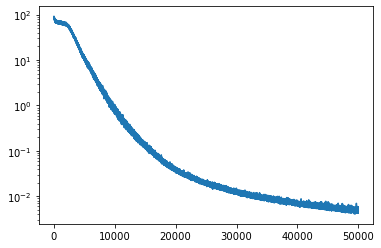

In [11]:
fig, ax = plt.subplots(1, 1)
ax.plot(losses)
ax.set_yscale('log')

In [12]:
torch.save(hypersolver, 'saved_models/hs_torchdyn.pt')

In [13]:
# hypersolver = torch.load('saved_models/hs_torchdyn.pt').to(device)

## Purely data-driven approach

In [14]:
class ControlledDataDrivenModel(nn.Module):
    """
    Data driven model of a controlled data-driven model
    """
    def __init__(self, net, u):
        super().__init__()
        self.net = net # data-driven model including the controller
        self.u = u # controller (nn.Module)
        self.nfe = 0 # number of function evaluations
        self.cur_u = None # current controller evaluation 
        
    def forward(self, t, x):
        self.nfe += 1
        self.cur_u = self.u(t, x)
        dx = self.net(t, x, self.cur_u)
        return dx
    
class ModelNet(nn.Module):
    '''Simple MLP'''
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(3, 64),
                                 nn.Softplus(),
                                 nn.Linear(64, 64),
                                 nn.Softplus(),
                                 nn.Linear(64, 64),
                                 nn.Tanh(),
                                 nn.Linear(64, 2))
        
    def forward(self, t, x, u):
        return self.net(torch.cat([x, u], -1))

In [15]:
model_net = ModelNet()
data_driven_sys = ControlledDataDrivenModel(model_net, RandConstController())

### Training the data-driven model

In [16]:
opt = torch.optim.Adam(data_driven_sys.net.parameters(), lr=3e-4)
loss_func = nn.MSELoss()
epochs = 50000 
bs = 2048
span = torch.linspace(0, dt, 2)
losses = []

for i in range(epochs):
    # Sample random intial states and controllers
    x0 = init_dist.sample((bs,)).to(device)
    control_input = torch.Tensor(bs, 1).uniform_(-5, 5).to(device)
    sys.u.u0 = control_input; data_driven_sys.u.u0 = control_input
    
    # Compute one step trajectory
    _, sol_gt = odeint(sys, x0, span, solver='tsit5', atol=1e-5, rtol=1e-5)
    _, sol_net = odeint(data_driven_sys, x0, span, solver='tsit5', atol=1e-5, rtol=1e-5)
    loss = loss_func(sol_gt, sol_net)

    # Optimization step
    loss.backward(); opt.step(); opt.zero_grad()
    print(f'Step: {i}, Loss: {loss:.6f}', end='\r')
    losses.append(loss.detach().cpu().item())

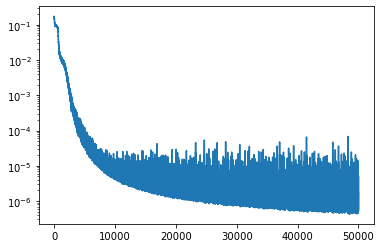

In [17]:
fig, ax = plt.subplots(1, 1)
ax.plot(losses)
ax.set_yscale('log')

In [18]:
torch.save(data_driven_sys.net, 'saved_models/pure_data_driven.pt')

### Uncontrolled trajectories

Text(0.5, 0.98, 'Uncontrolled Trajectories')

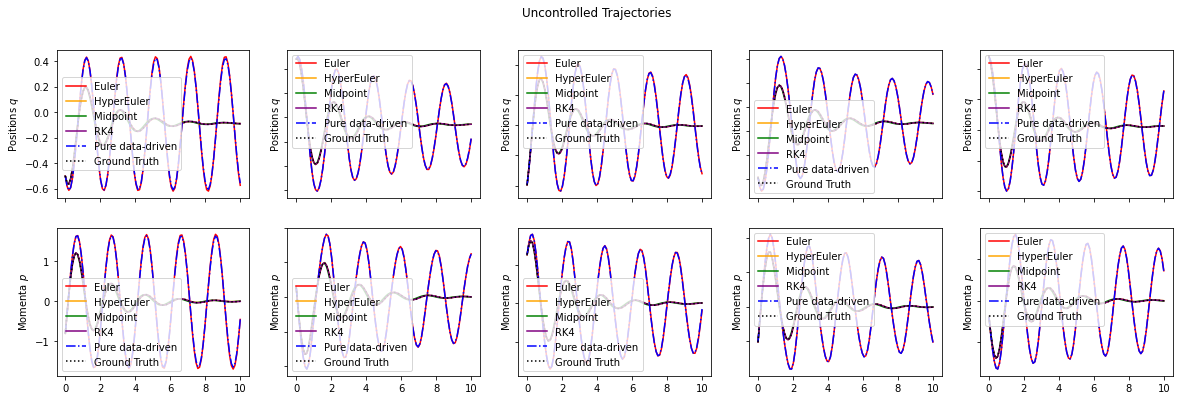

In [34]:
# Sample and plot some trajectories
x0 = π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0]), torch.Tensor([x0, x0]))
x0 = init_dist.sample((10000,)).to(device)
sys = ControlledPendulum(RandConstController()).to(device)
control_input = torch.Tensor(10000, 1).uniform_(-3,3).to(device)

# Uncontrolled system
# control_input = torch.zeros(10000, 1)
sys.u.u0 = control_input; data_driven_sys.u.u0 = control_input

tf = 10
t_span = torch.linspace(0, tf, int(tf/dt)+1).to(device)

# Purely data-driven
_, traj_dd = odeint(data_driven_sys, x0, t_span, solver='euler') # we use rk4 to show that no matter how many times the VF is sampled, pure data-driven cannot compete with the hypersolver approach

# Hypersolver (analytical + data-driven)
_, traj_hyper = odeint(sys, x0, t_span, solver=hypersolver)

# Analytical methods
_, traj_euler = odeint(sys, x0, t_span, solver='euler')
_, traj_mp = odeint(sys, x0, t_span, solver='midpoint')
_, traj_rk4 = odeint(sys, x0, t_span, solver='rk4')
_, traj_gt = odeint(sys, x0, t_span, solver='tsit5', atol=1e-5, rtol=1e-5)
traj_euler = traj_euler.detach().cpu(); traj_hyper = traj_hyper.detach().cpu(); traj_gt = traj_gt.detach().cpu()
traj_mp = traj_mp.detach().cpu(); traj_rk4 = traj_rk4.detach().cpu()
traj_dd = traj_dd.detach().cpu()
t_span = t_span.cpu()

fig, axs = plt.subplots(2, 5, figsize=(20,6))

for i in range(5):
    for j in range(2):
        axs[j, i].plot(t_span, traj_euler[:,i,j], 'r')
        axs[j, i].plot(t_span, traj_hyper[:,i,j], 'orange')
        axs[j, i].plot(t_span, traj_mp[:,i,j], 'green')
        axs[j, i].plot(t_span, traj_rk4[:,i,j], 'purple')
        axs[j, i].plot(t_span, traj_dd[:,i,j], 'b-.')
        axs[j, i].plot(t_span, traj_gt[:,i,j], 'k:')
        axs[j, i].legend(['Euler', 'HyperEuler', 'Midpoint', 'RK4', 'Pure data-driven', 'Ground Truth'])
        axs[j, i].label_outer()
    axs[0, i].set_ylabel(r'Positions $q$'); axs[1, i].set_ylabel(r'Momenta $p$')

fig.suptitle('Uncontrolled Trajectories')

Text(0.5, 0.98, 'SMAPE Propagation')

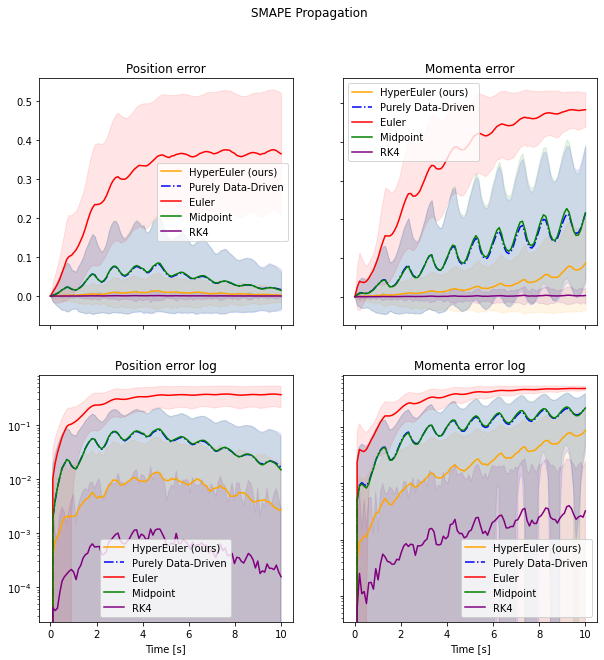

In [32]:
# Error analysis
def smape(yhat, y):
    return torch.abs(yhat - y) / (torch.abs(yhat) + torch.abs(y)) / 2

err_dd = smape(traj_gt, traj_dd).detach().cpu()
err_euler = smape(traj_gt, traj_euler).detach().cpu();  err_hyper = smape(traj_gt, traj_hyper).detach().cpu()
err_mp, err_rk4 = smape(traj_gt, traj_mp).detach().cpu(), smape(traj_gt, traj_rk4).detach().cpu()

mean_dd, std_dd = err_dd.mean(1), err_dd.std(1)
mean_euler, std_euler = err_euler.mean(1), err_euler.std(1)
mean_hyper, std_hyper = err_hyper.mean(1), err_hyper.std(1)
mean_mp, std_mp = err_mp.mean(1), err_mp.std(1)
mean_rk4, std_rk4 = err_rk4.mean(1), err_rk4.std(1)

fig = plt.figure(figsize=(10,10))

alpha = .1

def plot_errors(ax, var=0, title='Positions', scale=None):
    ax.plot(t_span, mean_hyper[:,var], 'orange', label='HyperEuler (ours)')
    ax.plot(t_span, mean_dd[:,var], 'b-.', label='Purely Data-Driven')
    ax.plot(t_span, mean_euler[:,var], 'r', label='Euler')
    ax.plot(t_span, mean_mp[:,var], 'green', label='Midpoint')
    ax.plot(t_span, mean_rk4[:,var], 'purple', label='RK4')

    ax.fill_between(t_span, mean_euler[:,var]-std_euler[:,var], mean_euler[:,var]+std_euler[:,var], alpha=alpha, color='r')
    ax.fill_between(t_span, mean_hyper[:,var]-std_hyper[:,var], mean_hyper[:,var]+std_hyper[:,var], alpha=alpha, color='orange')
    ax.fill_between(t_span, mean_mp[:,var]-std_mp[:,var], mean_mp[:,var]+std_mp[:,var], alpha=alpha, color='green')
    ax.fill_between(t_span, mean_rk4[:,var]-std_rk4[:,var], mean_rk4[:,var]+std_rk4[:,var], alpha=alpha, color='purple')
    ax.fill_between(t_span, mean_dd[:,var]-std_dd[:,var], mean_dd[:,var]+std_dd[:,var], alpha=alpha, color='blue')
    ax.legend()
    if scale is not None:
        ax.set_yscale(scale)
    ax.set_title(title)
    ax.set_xlabel('Time [s]')
    ax.label_outer()
    
ax = fig.add_subplot(2,2,1)
plot_errors(ax, 0, 'Position error')

ax = fig.add_subplot(2,2,2)
plot_errors(ax, 1, 'Momenta error')

ax = fig.add_subplot(2,2,3)
plot_errors(ax, 0, 'Position error log', 'log')

ax = fig.add_subplot(2,2,4)
plot_errors(ax, 1, 'Momenta error log', 'log')


fig.suptitle('SMAPE Propagation')

## Comment
We can see that even if the data-driven vector field can learn the dynamics, even by integrating it for more times (in this case, with `RK4`), it still does not reach the `hypersolver` performance.\
Even if it did, we notice that it usually requires a larger network and more NFE. Most importantly, there is no error bound for this.
Here is a summary:

<center>

|                    | Classical | Hypersolvers             | Purely data-driven* |
|-------------------|----------------|--------------------------|--------------------|
| Vector field              | Analytical     | Analytical + data-driven | Data-driven        |
| ODE solver              | Classical     | Classical | Classical        |
| Network size      | n/a            | Smaller                  | Bigger             |
| Error bounds      | ☑️              | ☑️                        | ✘**                 |
| Pareto optimality | ✘              | ☑️                        | ✘                  |

